# RAPS with RESICS45

If you are working with this notebook in a Google Colab Notebook environment, don't forget to change the Runtime to GPU.

In [ ]:
%pip install lightning-uq-box
%pip install torchgeo
%pip install --upgrade --no-cache-dir gdown rarfile

## Imports

In this notebook, we will demonstrate how you can use a posthoc conformal method like Regularized Adaptive Prediction Sets (RAPS) [Angelopoulos et al. 2021](https://arxiv.org/abs/2009.14193) on an Earth Observation (EO) Classification Task, namely the RESISC45 Dataset. For the dataloading we will use the [TorchGeo library](https://torchgeo.readthedocs.io/en/stable/), which you will need to install to run this tutorial (`pip install torchgeo`). Additionally, we will show how you can use a pretrained model - specific to EO data and apply RAPS for improved uncertainty quantification (UQ), specifically Empirical Coverage. The aim is not to boost accuracy, but simply demonstrate, how you you might be able to apply RAPS to your task at hand.

In [2]:
import os
from torchgeo.datamodules import RESISC45DataModule
from torchgeo.models import ResNet18_Weights
from lightning_uq_box.uq_methods import RAPS

from lightning.pytorch.loggers import CSVLogger
import torch
from lightning import Trainer
import tempfile
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor
from torch import Generator
from lightning_uq_box.viz_utils import plot_training_metrics
from torchgeo.trainers import ClassificationTask
from lightning_uq_box.uq_methods.metrics import EmpiricalCoverage, SetSize
from torchmetrics import CalibrationError, MetricCollection, Accuracy

%load_ext autoreload
%autoreload 2

## Datamodule

We need to adapt the default DataModule to support a calibration dataset that is separate from the validation set.

In [69]:
class RESISC45DataModuleWithCalib(RESISC45DataModule):
    def setup(self, stage: str) -> None:
        """Setup datasets with calibration.

        Args:
            stage: Either 'fit', 'validate', 'test', or 'predict'
        """
        if stage in ["fit"]:
            self.train_dataset = self.dataset_class(  # type: ignore[call-arg]
                split="train", **self.kwargs
            )
        if stage in ["fit", "validate"]:
            self.val_dataset = self.dataset_class(  # type: ignore[call-arg]
                split="val", **self.kwargs
            )
            # further split the validation set into a calibration set and a test set
            self.val_dataset, self.calib_dataset = torch.utils.data.random_split(
                self.val_dataset,
                [len(self.val_dataset) - 200, 200],
                generator=Generator().manual_seed(0),
            )
            self.calib_batch_size = self.val_batch_size
        if stage in ["test"]:
            self.test_dataset = self.dataset_class(  # type: ignore[call-arg]
                split="test", **self.kwargs
            )

    def calibration_dataloader(self):
        """Calibration Dataloader."""
        return self._dataloader_factory("calib")

In [70]:
datamodule = RESISC45DataModuleWithCalib(
    root=".", num_workers=2, batch_size=256, download=True
)
# setup manually so we can access val_loader
datamodule.setup("fit")
NUM_CLASSES = 45

Additionally, we need to consider that the normalization and possible augmentations for this datamodule are applied only through the lightning `on_after_batch_transfer()` function because that is recommended for efficiency. We will write a collate function that will apply the augmentation to the batch.

In [71]:
def normalization_collate_fn(batch):
    """Collate function for normalization."""
    images = torch.stack([item["image"] for item in batch])
    labels = torch.stack([item["label"] for item in batch])
    return datamodule.aug({"image": images, "label": labels})

We will use the validation and calibration loaders several times, so we will now define them with the collate function.

In [72]:
val_loader = datamodule.val_dataloader()
val_loader.collate_fn = normalization_collate_fn
calib_loader = datamodule.calibration_dataloader()
calib_loader.collate_fn = normalization_collate_fn

## Pretrained Model

We will use pretrained weights for Sentinel 2 data from the SSL4EO paper [Wang et al. 2022](https://arxiv.org/abs/2211.07044) that are accessible through TorchGeo. Let's first look at the predictions from the pretrained model so that we can later see the impact of RAPS. We will use a Lightning base class `ClassificationTask` from Torchgeo which will iterate over the dataloader and compute and store the metrics we are interested in. We will only finetune the classification head (`freeze_backbone=True`).

In [73]:
weights = ResNet18_Weights.SENTINEL2_RGB_MOCO
in_chans = weights.meta["in_chans"]

base_model = ClassificationTask(
    model="resnet18",
    loss="ce",
    weights=weights,
    in_channels=in_chans,
    num_classes=NUM_CLASSES,
    lr=0.03,
    patience=5,
    freeze_backbone=True,
)

metrics = MetricCollection(
    {
        "OverallAccuracy": Accuracy(
            num_classes=NUM_CLASSES, average="micro", task="multiclass"
        ),
        "Calibration": CalibrationError(num_classes=NUM_CLASSES, task="multiclass"),
        "Coverage": EmpiricalCoverage(),
        "SetSize": SetSize(),
    }
)
base_model.train_metrics = metrics.clone(prefix="train_")
base_model.val_metrics = metrics.clone(prefix="val_")
base_model.test_metrics = metrics.clone(prefix="test_")

## Predictions with Pretrained Model

We have finetuned a model for 50 epochs with the code below and stored the checkpoint, so you don't have to rerun the training for the tutorial purpose. If you want to change the model training and see the effects set `USE_CHECKPOINT=False`.

In [ ]:
import gdown

url = "https://drive.google.com/uc?id=1QulRPS2BNX8PLt9ur0EmeeqLe0__--vs"
ckpt_path = "./resics45_resnet18.ckpt"
gdown.download(url, ckpt_path, quiet=False)

USE_CHECKPOINT = True

In [75]:
base_dir = tempfile.mkdtemp()

base_trainer = Trainer(
    devices=[0],
    accelerator="gpu",
    default_root_dir=base_dir,
    max_epochs=50,
    logger=CSVLogger(base_dir),
    log_every_n_steps=1,
    enable_progress_bar=True,
)

# evaluate or finetune pretrained model
if USE_CHECKPOINT:
    base_trainer.test(model=base_model, ckpt_path=ckpt_path, dataloaders=val_loader)
else:
    base_trainer.fit(base_model, datamodule=datamodule)
    # evaluate on validation set
    base_trainer.test(ckpt_path="best", dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmpzspnejoh/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | ResNet           | 11.2 M
---------------------------------------------------
23.1 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.798    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /tmp/tmpzspnejoh/lightning_logs/version_0/checkpoints/epoch=49-step=3700.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
Loaded model weights from the checkpoint at /tmp/tmpzspnejoh/lightning_logs/version_0/checkpoints/epoch=49-step=3700.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_Calibration      │   0.022385064512491226    │
│       test_Coverage       │    0.7924590110778809     │
│   test_OverallAccuracy    │    0.7924590110778809     │
│       test_SetSize        │            1.0            │
│         test_loss         │    0.6630579233169556     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6630579233169556,
  'test_Calibration': 0.022385064512491226,
  'test_Coverage': 0.7924590110778809,
  'test_OverallAccuracy': 0.7924590110778809,
  'test_SetSize': 1.0}]

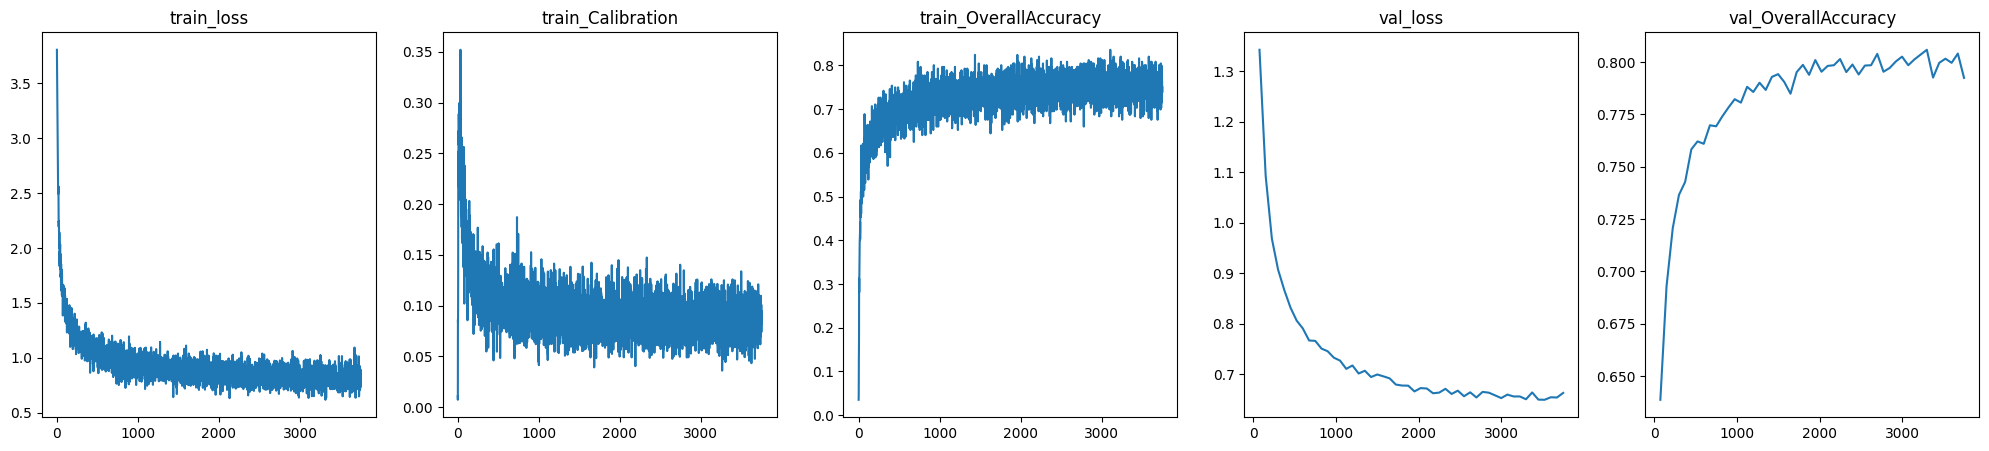

In [76]:
if USE_CHECKPOINT:
    pass
else: # plot training and val metrics
    fig = plot_training_metrics(
        os.path.join(base_dir, "lightning_logs"),
        [
            "train_loss",
            "train_Calibration",
            "train_OverallAccuracy",
            "val_loss",
            "val_OverallAccuracy",
        ],
    )

## Apply RAPS

RAPS is a Conformal Prediction method, which is a framework that can provide coverage guarantees, meaning the frequency with which the true class is contained in the set of predictions. In the standard classification framework, the prediction set just containes a single class (the one with the highest softmax score). In contrast, RAPS gives you a prediction set that can contain multiple classes. More precisely, it constructs a prediction set of minimal size such that it fullfills a theoretically guaranteed desired marginal coverage. For a phenomenal introduction to Conformal Prediction see this [Intro Tutorial](https://people.eecs.berkeley.edu/~angelopoulos/blog/posts/gentle-intro/), and for more details about RAPS we refer to the [paper](https://arxiv.org/abs/2009.14193). The desired coverage is controlled via the `alpha` parameter, where `1-alpha` is the desired coverage (a common default is `alpha=0.1` so a coverage rate of 90%).

In [78]:
metrics = MetricCollection(
    {
        "OverallAccuracy": Accuracy(
            num_classes=NUM_CLASSES, average="micro", task="multiclass"
        ),
        "Calibration": CalibrationError(num_classes=NUM_CLASSES, task="multiclass"),
        "Coverage": EmpiricalCoverage(topk=None),
        "SetSize": SetSize(topk=None),
    }
)

In [79]:
raps_dir = tempfile.mkdtemp()
raps = RAPS(model=base_model.model, alpha=0.1)
raps.input_key = "image"
raps.target_key = "label"
raps.test_metrics = metrics.clone(prefix="test_")

raps_trainer = Trainer(
    devices=[0], accelerator="gpu", default_root_dir=raps_dir, inference_mode=False
)

raps_trainer.validate(raps, dataloaders=calib_loader)
raps_trainer.test(raps, dataloaders=val_loader)

/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-p ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmp4dgi21da/lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_Calibration      │    0.06677114963531494    │
│       test_Coverage       │    0.9213114976882935     │
│   test_OverallAccuracy    │    0.7924590110778809     │
│       test_SetSize        │    2.4544262886047363     │
│         test_loss         │     3.175469398498535     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 3.175469398498535,
  'test_Calibration': 0.06677114963531494,
  'test_Coverage': 0.9213114976882935,
  'test_OverallAccuracy': 0.7924590110778809,
  'test_SetSize': 2.4544262886047363}]

Based on the Coverage metric, we can see a signifcant improvement over the deterministic model. With that the set size has also increased. Now we have a principled way of not just returning a single prediction but instead a set of predictions, that have a theoretical guarantee of desired marginal coverage.

## Example Visualization

In [126]:
predict_batch = next(iter(val_loader))

preds = raps.predict_step(predict_batch["image"])
print(preds.keys())

dict_keys(['pred', 'pred_uct', 'logits', 'pred_set', 'size'])


In [127]:
preds["pred"].shape
dataset = datamodule.train_dataloader().dataset
class_labels = dataset.classes

In [128]:
def plot_random_sample(
    preds: dict[str, Tensor], images: Tensor, true_labels: Tensor, class_labels: list
) -> None:
    """Plot a random sample from the prediction batch.

    Args:
        preds: dictionary containing 'pred' and 'pred_set'
        images: array of input images
        class_labels: list of class labels
    """
    # Select a random index from the prediction batch
    idx = np.random.randint(len(images))

    # Get the prediction set for the selected sample
    pred_set = preds["pred_set"][idx].numpy()
    mean_preds = preds["pred"][idx].numpy()

    # Get the corresponding class labels for the prediction set
    pred_labels = [class_labels[i] for i in pred_set]
    true_label = class_labels[true_labels[idx]]

    image = images[idx]
    image = np.transpose(
        (image * datamodule.std[:, None, None] + datamodule.mean[:, None, None]) / 255,
        (1, 2, 0),
    )

    # Sort the mean predictions and corresponding class labels from high to low
    sorted_indices = np.argsort(mean_preds[pred_set])[::-1]
    sorted_mean_preds = mean_preds[pred_set][sorted_indices]
    sorted_pred_labels = [pred_labels[i] for i in sorted_indices]

    # Plot the input image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Input Image")

    # Plot the prediction set
    plt.subplot(1, 2, 2)
    plt.bar(range(len(sorted_mean_preds)), sorted_mean_preds)
    plt.xticks(range(len(sorted_mean_preds)), sorted_pred_labels, rotation=60)
    plt.title("Temp Scaled Logit Predictions")

    # Add the true label to the title
    plt.suptitle(
        f'Prediction Set: ({", ".join(sorted_pred_labels)})\nTrue Label: {true_label}'
    )
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


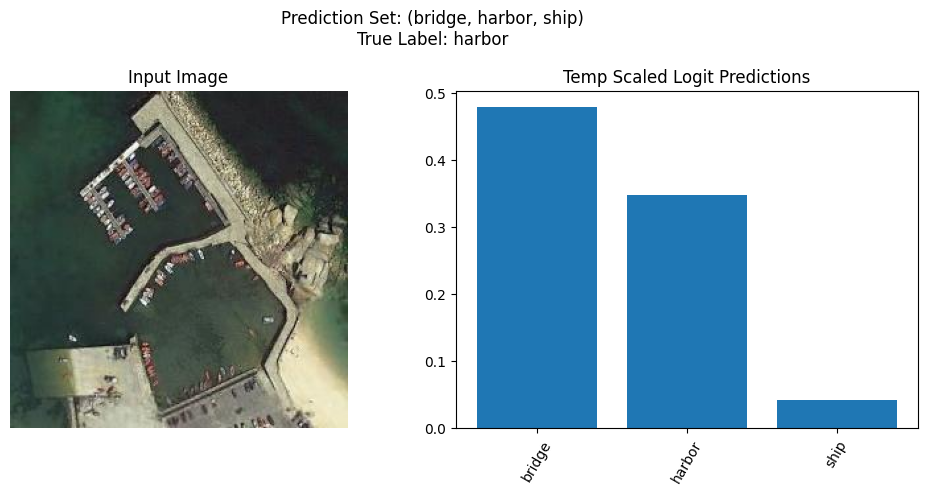

In [150]:
plot_random_sample(preds, predict_batch["image"], predict_batch["label"], class_labels)